# Phase 1 - Ingestion and Cleaning

In the Phase 2 of the Case Study, we will carry out the following steps:
  - Ingest raw downloaded data
  - Output a combined dataset ready for analysis and modeling

In [1]:
import pandas as pd
import os
from sys import platform
import matplotlib.pyplot as plt
import datetime
import numpy as np
import pickle
import seaborn
from os import listdir
from os.path import isfile, join

In [2]:
# A helper function that you'll be using while reading the raw files
def is_integer(x):
    '''
    This function returns True if x is an integer, and False otherwise
    '''
    try:
        return (int(x) == float(x))
    except:
        return False

## Parameters

In [3]:
# Define the directories that contain the files downloaded
dir_cs = './case_study_data' # path to the directory where all the *.csv.zip files are located

# Define the output path for the pickle
pickle_file = '' + "clean_data.pickle" # path to save cleaned data

In [4]:
# Identify the columns we'll be keeping from the dataset
cols_to_pick = ['id',
'loan_amnt', 'funded_amnt', 'term', 'int_rate', 'installment', 'grade', 'emp_length',
'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'loan_status',
'purpose', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'open_acc', 'pub_rec',
'fico_range_high', 'fico_range_low', 'revol_bal', 'revol_util', 'total_pymnt',
'last_pymnt_d', 'recoveries'] # list of features to use for this study as indicated in the handout

# Identify the type of each of these column based on your CS-Phase 1 response
float_cols = ['loan_amnt','funded_amnt', 'installment','annual_inc','dti','delinq_2yrs',
             'open_acc', 'pub_rec','fico_range_high', 'fico_range_low','revol_bal','total_pymnt','recoveries']
cat_cols = ['term','grade','emp_length','home_ownership','verification_status',
            'loan_status','purpose'] # categorical features
perc_cols = ['int_rate', 'revol_util']
date_cols = ['issue_d', 'earliest_cr_line', 'last_pymnt_d']

# Ensure that we have types for every column
assert set(cols_to_pick) - set(float_cols) - set(cat_cols) - set(perc_cols) - set(date_cols) == set(["id"])

In [5]:
# Some of the columns selected will not be used directly in the model,
# but will be used to generate other features.
#
# Create variables specifying the features that will be used

# All categorical columns other than "loan_status" will be used as
# discrete features

discrete_features = list(set(cat_cols) - set(["loan_status"]))

# All numeric columns will be used as continuous features
continuous_features = list(float_cols + perc_cols)

## Ingestion
Ingest the data files from both sets, perform consistency checks, and prepare one single file for each set

In [6]:
def ingest_files(directory):
    '''
    This function will ingest every file in the specified directory
    into a pandas dataframe. It will return a dictionary containing
    these dataframes, keyed by the file name.
    
    We assume the directory contains files directly downloaded from
    the link given in the handout, and *only* those files. Thus, we 
    assume the files are zipped (pd.read_csv can read zipped files) 
    and we assume the first line in each file needs to be skipped.
    
    Note that each file will be read *without* formatting
    '''
    
    # If the directory has no trailing slash, add one
    if directory[-1] != "/":
        directory += "/"
    all_files = [] # get list of all files from the directory
    for filename in listdir(directory):
        if isfile(join(directory, filename)):
            all_files.append(filename)
    output = {}
    
    print("Directory " + directory + " has " + str(len(all_files)) + " files:")
    for i in all_files:
        print("    Reading file " + i)
        f = directory+'/'+i
        output[i] = pd.read_csv(f, dtype='str', skiprows=1) # read each with dtype='str' and skip_rows =1
#         Some of the files have "summary" lines that, for example
#         read "Total number of loans number in Policy 1: ....."
#         To remove those lines, find any lines with non-integer IDs
#         and remove them
        invalid_rows = ~output[i]['id'].apply(is_integer)  # mask rows that have non-integer IDs. Use is_integer method
        output[i]['Filter'] = invalid_rows
        if invalid_rows.sum() > 0:
            print("Found " + str(invalid_rows.sum()) + " invalid rows which were removed")
            output[i] = output[i][output[i]['Filter']==False] # remove invalid rows
            del output[i]['Filter']
    
    return output # return dictionary of dataframe

In [7]:
# Ingest the set of files we downloaded using the defined method "ingest_files"
files_cs = ingest_files(dir_cs) # dictioary of (filename, dataframe) as (key, value)

Directory ./case_study_data/ has 12 files:
    Reading file LoanStats3a_securev1.csv.zip
Found 3 invalid rows which were removed
    Reading file LoanStats3b_securev1.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats3c_securev1.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats3d_securev1.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats_securev1_2016Q1.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats_securev1_2016Q2.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats_securev1_2016Q3.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats_securev1_2016Q4.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats_securev1_2017Q1.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats_securev1_2017Q2.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats_securev1_2017Q3.csv.zip
Found 2 invalid 

### Combine the files

In [8]:
data_cs = pd.concat(files_cs.values(), ignore_index=True)
 # combine "files_cs" into a pandas dataframe
              # resent index with drop = True

In [9]:
data_cs.columns

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       ...
       'hardship_payoff_balance_amount', 'hardship_last_payment_amount',
       'disbursement_method', 'debt_settlement_flag',
       'debt_settlement_flag_date', 'settlement_status', 'settlement_date',
       'settlement_amount', 'settlement_percentage', 'settlement_term'],
      dtype='object', length=151)

## Prepare Final Dataset

In [10]:
# Keep only the columns of interest from 'data_cs'
final_data = data_cs[cols_to_pick]

In [11]:
final_data.shape

(1765426, 26)

In [13]:
print("Starting with " + str(len(final_data)) + " rows")

Starting with 1765426 rows


In [14]:
# Define the directories that contain the files downloaded
dir_cs = './case_study_data' # path to the directory where all the *.csv.zip files are located

# Define the output path for the pickle
pickle_file = '' + "raw_data.pickle" # path to save cleaned data

In [16]:
final_data.columns

Index(['id', 'loan_amnt', 'funded_amnt', 'term', 'int_rate', 'installment',
       'grade', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'issue_d', 'loan_status', 'purpose', 'dti',
       'delinq_2yrs', 'earliest_cr_line', 'open_acc', 'pub_rec',
       'fico_range_high', 'fico_range_low', 'revol_bal', 'revol_util',
       'total_pymnt', 'last_pymnt_d', 'recoveries'],
      dtype='object')

In [17]:
final_data.to_csv('raw_data', sep=',')

### Typecast the columns

In [12]:
import warnings
warnings.filterwarnings('ignore')

In [13]:
# Remember that we read the data as string (without any formatting). 
# Now we would typecast the columns based on feature types which you found out in CS Phase 1

for i in float_cols:
    final_data[i] = final_data[i].astype(float)            # typecast float columns

In [14]:
def clean_perc(x):
    if pd.isnull(x):
        return np.nan
    else:
        return float(x.strip()[:-1])
    
for i in perc_cols:
    final_data[i] = final_data[i].apply(clean_perc) # apply clean_perc to percentage columns

In [15]:
def clean_date(x):
    if pd.isnull(x):
        return None
    else:
        return datetime.datetime.strptime( x, "%b-%Y").date()

for i in date_cols:
    final_data[i] = final_data[i].apply(clean_date)  # typecast date cloumns to datatime using clean_date

In [16]:
for i in cat_cols:
    # for categorical features if the value is null/empty set it to None
    final_data[i].replace(np.nan, None,inplace=True)
    final_data[i].replace('', None,inplace=True)

In [18]:
pickle_file = '' + "raw_data.pickle" 
pickle.dump( [final_data, discrete_features, continuous_features], open(pickle_file, "wb") )

## Calculate returns for each loan

In [18]:
# Define the names of the four returns we'll be calculating as described in Q.6
# ret_PESS: Pessimistic return
# ret_OPT: Optimistic return
# ret_INTa, ret_INTb: Method3 at two differnt values of "i"
ret_cols = ["ret_PESS", "ret_OPT", "ret_INTa", "ret_INTb"]

In [19]:
# Remove all rows for loans that were paid back on the days they were issued
final_data['loan_length'] = (final_data.last_pymnt_d - final_data.issue_d) / np.timedelta64(1, 'M')
n_rows = len(final_data)

final_data = final_data[final_data['loan_length']!=0] # select rows where loan_length is not 0. 

print("Removed " + str(n_rows - len(final_data)) + " rows")

Removed 6218 rows


### M1-Pessimistic Method

In [20]:
# Calculate the return using a simple annualized profit margin
# Pessimistic definition (Handout 6a.) (M1)

final_data['term_num'] = final_data.term.str.extract('(\d+)',expand=False).astype(int) # length of loan in months

final_data['ret_PESS'] = ((final_data['total_pymnt']- final_data['funded_amnt']) / final_data['funded_amnt'])* (12/final_data['term_num'])


### M2-Optimistic Method

In [21]:
# Assuming that if a loan gives a positive return, we can
# immediately find a similar loan to invest in; if the loan
# takes a loss, we use M1-pessimistic to compute the return

final_data['ret_OPT'] = ((final_data['total_pymnt'] - final_data['funded_amnt']) / final_data['funded_amnt'])* (12/final_data['loan_length'])

final_data.loc[final_data.ret_OPT < 0,'ret_OPT'] = final_data.loc[final_data.ret_OPT < 0,'ret_PESS']


### Method 3

In [22]:
def ret_method_3(T, i):
    '''
    Given an investment time horizon (in months) and re-investment
    interest rate, calculate the return of each loan
    '''
    
    # Assuming that the total amount paid back was paid at equal
    # intervals during the duration of the loan, calculate the
    # size of each of these installment
    actual_installment = (final_data.total_pymnt - final_data.recoveries) / final_data.loan_length

    # Assuming the amount is immediately re-invested at the prime
    # rate, find the total amount of money we'll have by the end
    # of the loan
    # compute the quantity given in [] in eq.2.3 of handout
    
    cash_by_end_of_loan = actual_installment * (1-(1+i)**final_data.loan_length)/(1-(1+i))
    
    cash_by_end_of_loan = cash_by_end_of_loan + final_data.recoveries
    
    # Assuming that cash is then re-invested at the prime rate,
    # with monthly re-investment, until T months from the start
    # of the loan
    remaining_months = T - final_data['loan_length']
    final_return = (cash_by_end_of_loan * (1+i)**remaining_months) - final_data.funded_amnt

    # Find the percentage return
    ret_val = (12/T) * final_return * (1/final_data.funded_amnt)
    return ret_val

In [23]:
final_data['ret_INTa'] = ret_method_3(T = 60,i = 0.002) # call ret_method_3 with T=60, i=0.002
final_data['ret_INTb'] = ret_method_3(T = 60,i = 0.005) # call ret_method_3 with T=60, i=0.005

In [24]:
pickle.dump( [final_data, discrete_features, continuous_features, ret_cols], open(pickle_file, "wb") )

### Visualize the variables

In [126]:
def visualize_float_columns():
    '''
    This function visualizes Box-and-whisker plots for continuous variables
    '''
    
    # FLoat columns
    for i in float_cols + perc_cols + ret_cols:
        seaborn.boxplot(final_data[i])

        # Print the three highest values
        highest_vals = final_data[i].nlargest(3).tolist() # get 3 highest values
        smallest_val = min(final_data[i])
        
        plt.text(smallest_val, -0.3, highest_vals[0])
        plt.text(smallest_val, -0.2, highest_vals[1])
        plt.text(smallest_val, -0.1, highest_vals[2])

        plt.show()

In [127]:
def visualize_cat_columns():
    '''
    Lists the distinct values for categorical columns
    '''
    # Categorical columns 
    for i in cat_cols:
        print(i) # print field name
        print(final_data[i].unique()) # print number of distinct values
        print(final_data[i].value_counts()) # for each distinct value print the number of occurances
        print("")
        print("")

In [128]:
def visualize_date_columns():
    '''
    This function visualizes a timeline density for dates
    '''
    
    # Date columns
    for i in date_cols:
        final_data[final_data[i].isnull() == False][i].apply(lambda x : str(x.year) +
                                                "-" + str(x.month)).value_counts(ascending = True).plot()
        plt.title(i + " (" + str(final_data[i].isnull().sum()) + " null values)")
        plt.show()

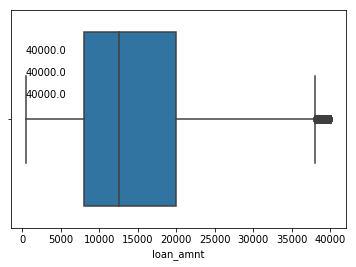

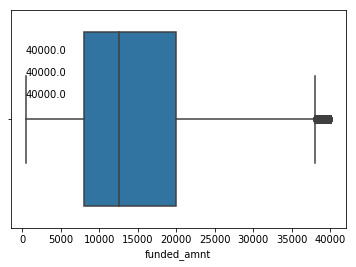

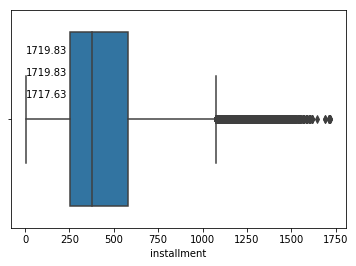

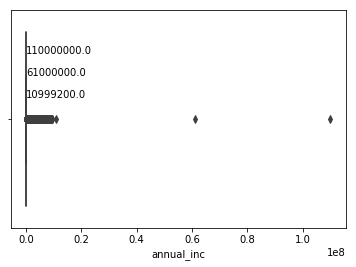

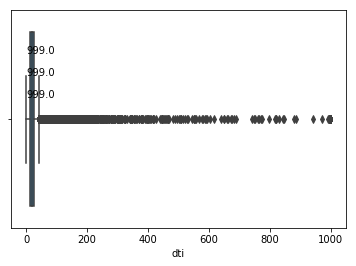

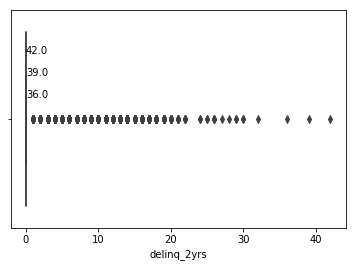

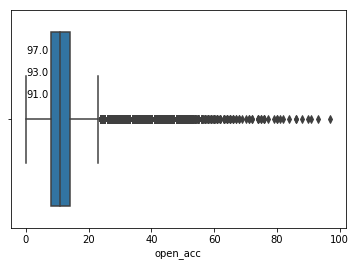

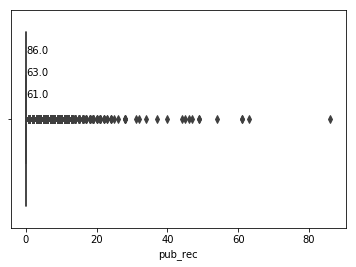

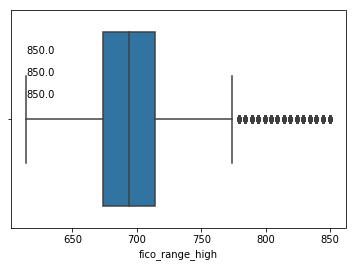

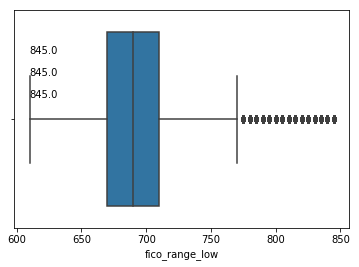

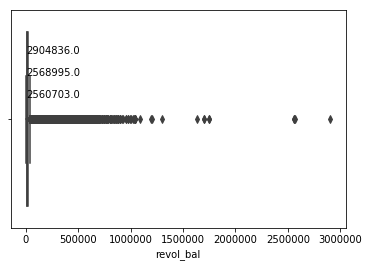

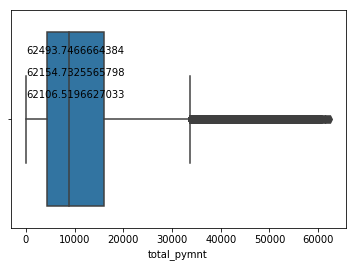

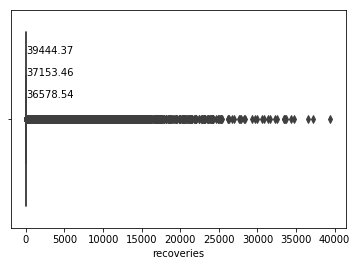

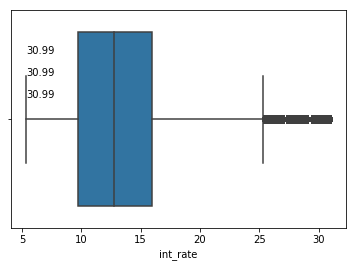

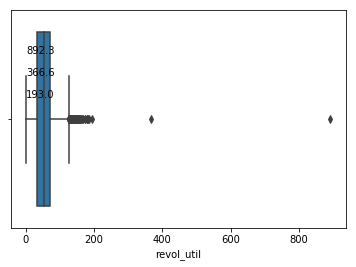

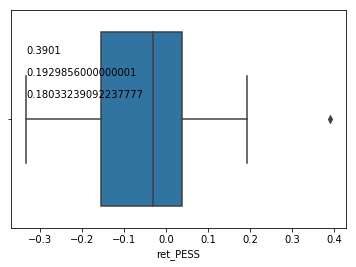

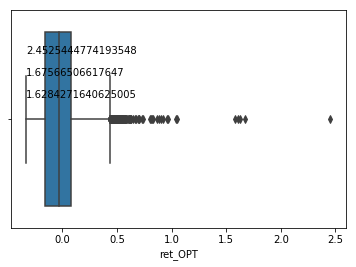

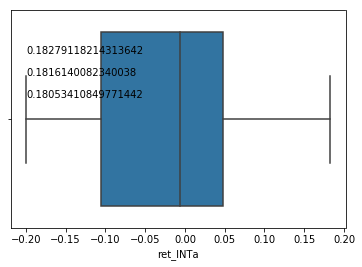

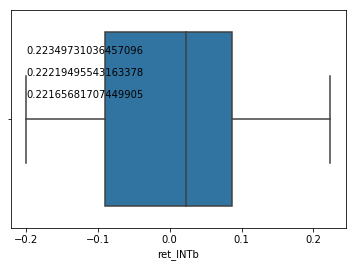

term
[' 36 months' ' 60 months']
 36 months    1260610
 60 months     498598
Name: term, dtype: int64


grade
['B' 'C' 'A' 'E' 'F' 'D' 'G']
C    521315
B    520527
A    296996
D    254390
E    116174
F     38424
G     11382
Name: grade, dtype: int64


emp_length
['10+ years' '< 1 year' '1 year' '3 years' '8 years' '9 years' '4 years'
 '5 years' '6 years' '2 years' '7 years']
10+ years    622666
2 years      168379
< 1 year     155375
3 years      148451
1 year       122173
5 years      115152
4 years      111678
6 years       85413
8 years       80388
7 years       78872
9 years       70661
Name: emp_length, dtype: int64


home_ownership
['RENT' 'OWN' 'MORTGAGE' 'OTHER' 'NONE' 'ANY']
MORTGAGE    869367
RENT        697215
OWN         191886
ANY            504
OTHER          182
NONE            54
Name: home_ownership, dtype: int64


verification_status
['Verified' 'Source Verified' 'Not Verified']
Source Verified    668294
Not Verified       561817
Verified           529097
Name: verifi

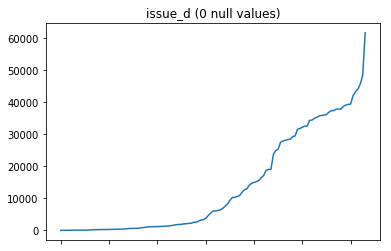

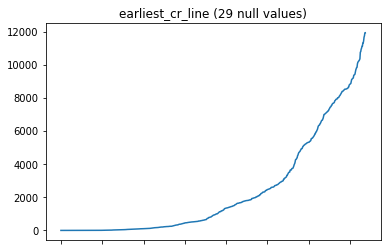

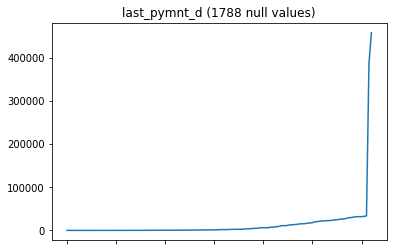

In [129]:
# visualize continuous features
visualize_float_columns()

# visulaize categorical features
visualize_cat_columns()

# visualize date columns
visualize_date_columns()

##### We have choosen to drop null values before handling outliers because, if we have null values, the data was even more skewed. As we ran couple of trials, we decided that dropping null values and then outliers will be more effective especially when deciding from box plot.

### Drop null values

In [130]:
# Deal with null values. We allow cateogrical variables to be null
# OTHER than grade, which is a particularly important categorical.
# All non-categorical variables must be non-null, and we drop
# rows that do not meet this requirement

required_cols = set(cols_to_pick) - set(cat_cols) - set(["id"])
required_cols.add("grade")
n_rows = len(final_data)

# drop rows that contain null based only on "required_cols"
final_data.dropna(subset=list(required_cols),inplace=True)


print("Removed " + str(n_rows - len(final_data)) + " rows")

Removed 3561 rows


### Handle outliers

We are calculating the 99 percentile in the data overall based on the columns choosen, and deleting outliers from overall data instead, removing from each column at a time.

In [132]:
# There are quite a few outliers. 
# Please identify top-k (decide this based on the visualization) features where outliers are most obvious
n_rows = len(final_data)

cols = ['loan_amnt','funded_amnt','installment','dti','total_pymnt','recoveries','int_rate','ret_PESS','ret_OPT']
final = final_data
for i in cols:
    p = np.percentile(final[i],99)
    final_data = final_data[final_data[i]<p]
print("Removed " + str(n_rows - len(final_data)) + " rows")

Removed 121548 rows


In [133]:
# Remove all loans that are still current
n_rows = len(final_data)

final_data = final_data[final_data.loan_status != 'Current']

print("Removed " + str(n_rows - len(final_data)) + " rows")

Removed 748745 rows


In [134]:
# Only include loans isssued since 2010
n_rows = len(final_data)

final_data = final_data[final_data.issue_d > datetime.datetime.strptime('2009-12-31', "%Y-%m-%d").date()]

print("Removed " + str(n_rows - len(final_data)) + " rows")

Removed 8073 rows


### Visualize clean data

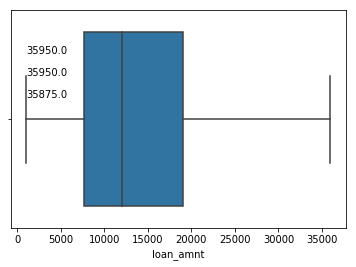

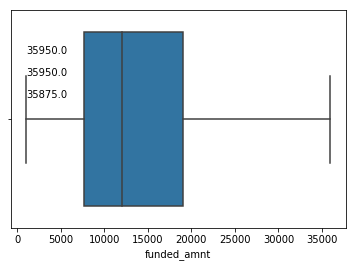

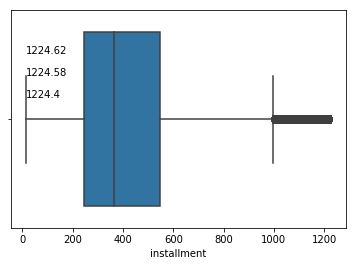

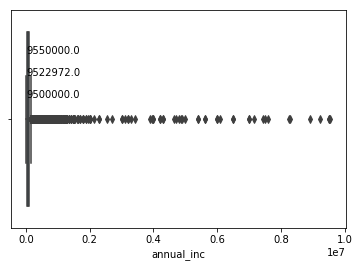

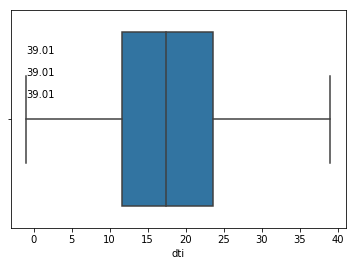

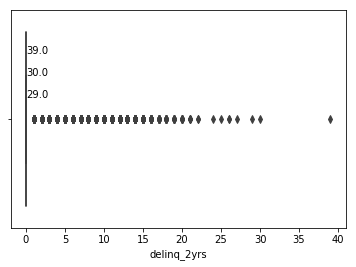

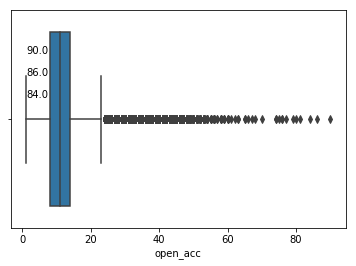

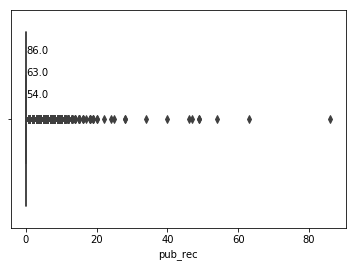

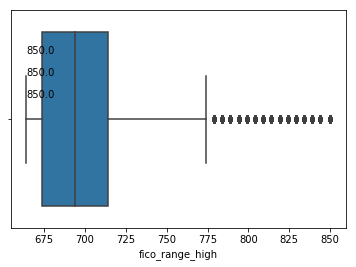

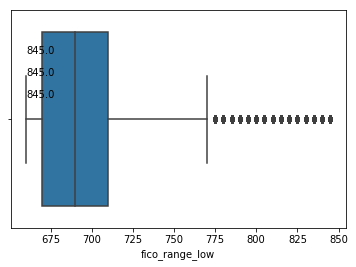

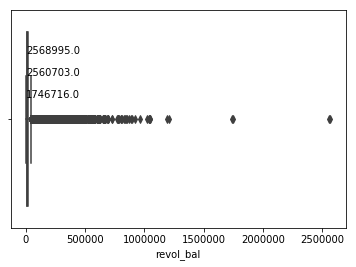

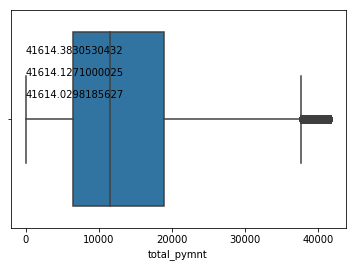

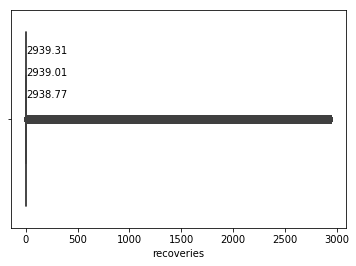

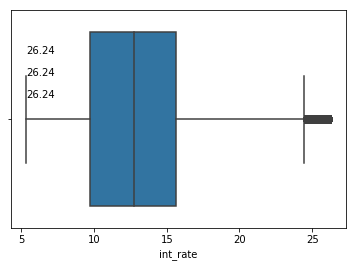

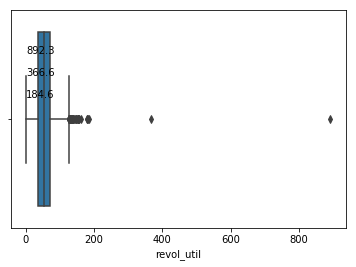

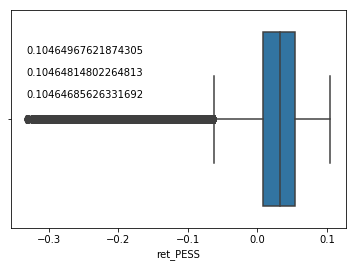

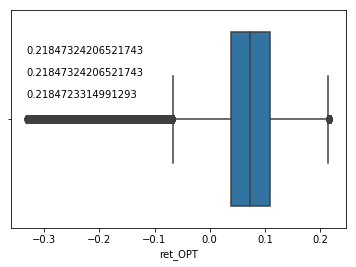

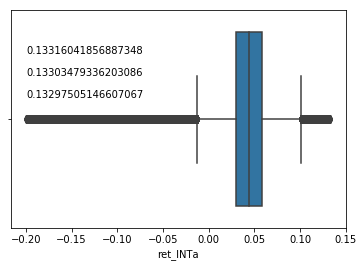

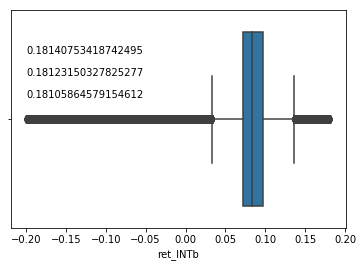

term
[' 36 months' ' 60 months']
 36 months    683575
 60 months    193706
Name: term, dtype: int64


grade
['B' 'C' 'A' 'E' 'F' 'D' 'G']
B    268916
C    257909
A    153983
D    130847
E     52271
F     11926
G      1429
Name: grade, dtype: int64


emp_length
['10+ years' '< 1 year' '1 year' '3 years' '8 years' '9 years' '4 years'
 '5 years' '6 years' '2 years' '7 years']
10+ years    300560
2 years       84422
3 years       74588
< 1 year      73796
1 year        61037
5 years       58832
4 years       55831
6 years       45001
8 years       43860
7 years       43440
9 years       35914
Name: emp_length, dtype: int64


home_ownership
['RENT' 'OWN' 'MORTGAGE' 'OTHER' 'NONE' 'ANY']
MORTGAGE    432924
RENT        353926
OWN          90232
ANY            120
OTHER           45
NONE            34
Name: home_ownership, dtype: int64


verification_status
['Verified' 'Source Verified' 'Not Verified']
Source Verified    327095
Not Verified       280615
Verified           269571
Name: verifica

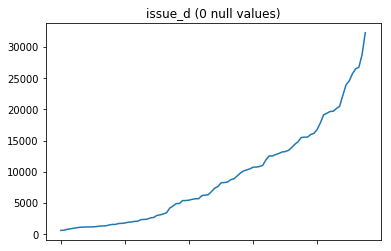

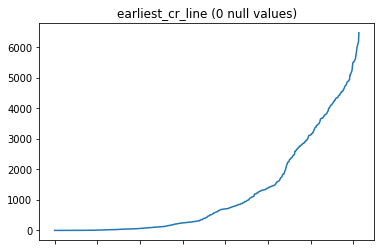

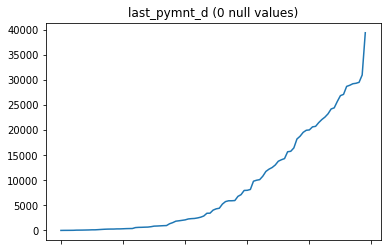

In [135]:
# Visualize the data again after cleaning
# visualize continuous features
visualize_float_columns()

# visulaize categorical features
visualize_cat_columns()

# visualize date columns
visualize_date_columns()

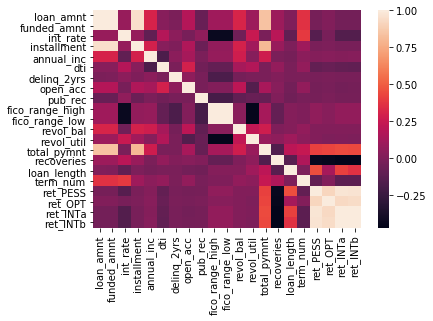

In [136]:
# Visualize the feature correlations
    # You can compute the correlation among features and display a heat-map of the matrix 
    # OR use sns scatter or pairplot

corr = final_data.corr()
seaborn.heatmap(corr, xticklabels=corr.columns.values,yticklabels=corr.columns.values)

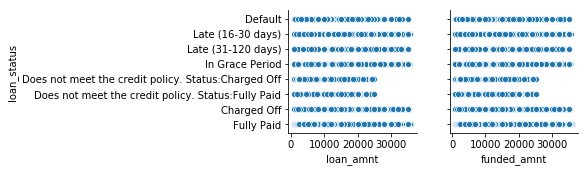

In [145]:
# Visualize relation between loan status and features
# sns pairplot or scatter plot. Refer to recitations
seaborn.pairplot(data=final_data, x_vars=float_cols[:2], y_vars='loan_status')

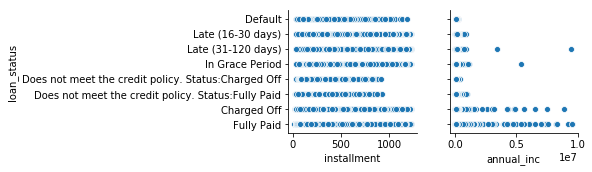

In [146]:
seaborn.pairplot(data=final_data, x_vars=float_cols[2:4], y_vars='loan_status')

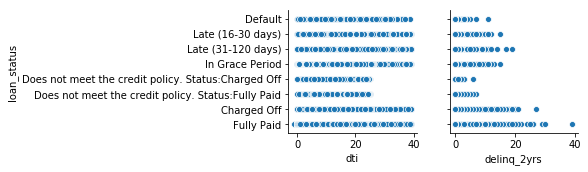

In [147]:
seaborn.pairplot(data=final_data, x_vars=float_cols[4:6], y_vars='loan_status')

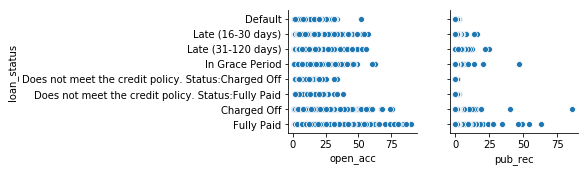

In [148]:
seaborn.pairplot(data=final_data, x_vars=float_cols[6:8], y_vars='loan_status')

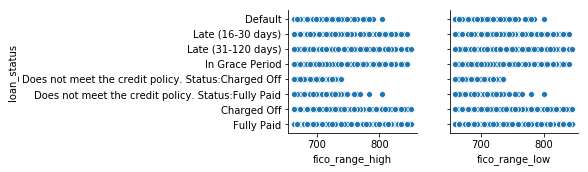

In [149]:
seaborn.pairplot(data=final_data, x_vars=float_cols[8:10], y_vars='loan_status')

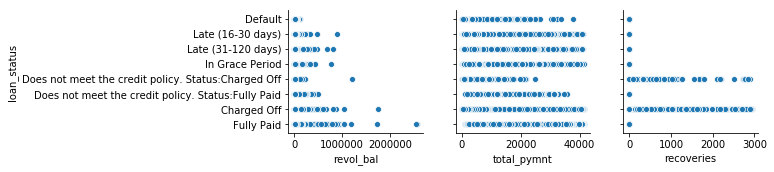

In [150]:
seaborn.pairplot(data=final_data, x_vars=float_cols[10:], y_vars='loan_status')

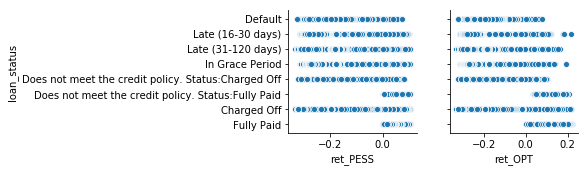

In [151]:
seaborn.pairplot(data=final_data, x_vars=['ret_PESS','ret_OPT'], y_vars='loan_status')

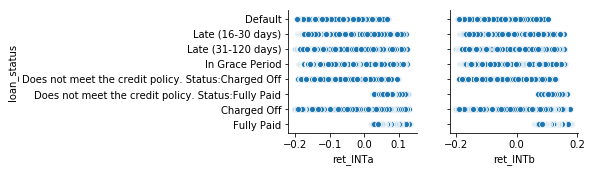

In [152]:
seaborn.pairplot(data=final_data, x_vars=['ret_INTa','ret_INTb'], y_vars='loan_status')

What do you observe after removing the outliers?

After seeing the visualizations, we have set our upper bound to be 99 percentile. As we do not have much outliers from lower bound, we are not removing them from the columns. We have removed outliers from these columns 'loan_amnt','funded_amnt','installment','dti','total_pymnt','recoveries','int_rate', as we are using these columns to calculate ret_PESS,ret_OPT, ret_INTa,ret_INTb i.e the returns in optimistic, pessimistic approaches, it is important for us to handle outliers.

After removing the outliers, the data has become more consistent, as before the presence of outliers affect the mean and median of data which effects the error in data set. This can be clearly seen from the plot for last_pymt_d, as before removing outliers, the data was highly skewed. But after removing, it has become consistent. 

### Data Exploration
Solution to Q.7 from the handout

In [142]:
# Find the percentage of loans by grade, the default by grade,
# and the return of each grade
perc_by_grade = (final_data.grade.value_counts()*100/len(final_data)).sort_index()

default_by_grade = final_data.groupby("grade").apply(lambda x : (x.loan_status != "Fully Paid").sum()*100/len(x) )
ret_by_grade_OPT = (final_data.groupby('grade')['ret_OPT'].mean())*100 # average return for M2-Optimistic for each loan grade
ret_by_grade_PESS = (final_data.groupby('grade')['ret_PESS'].mean())*100 # average return for M1-Pessimistic for each loan grade
ret_by_grade_INTa = (final_data.groupby('grade')['ret_INTa'].mean())*100 # average return for M3
ret_by_grade_INTb = (final_data.groupby('grade')['ret_INTb'].mean())*100 # average return for M3
int_rate_by_grade = final_data.groupby('grade')['int_rate'].mean() # average interest rate for each grade

combined = pd.DataFrame(perc_by_grade)
combined.columns = ['perc_of_loans']
combined['perc_default'] = default_by_grade
combined['avg_int_rate'] = int_rate_by_grade
combined['return_OPT'] = ret_by_grade_OPT
combined['return_PESS'] = ret_by_grade_PESS
combined['return_INTa'] = ret_by_grade_INTa
combined['return_INTb'] = ret_by_grade_INTb

combined

,perc_of_loans,perc_default,avg_int_rate,return_OPT,return_PESS,return_INTa,return_INTb
A,17.552301,7.211835,7.212996,3.712445,1.519637,3.046809,6.656576
B,30.653348,15.370971,10.833601,4.605019,1.246442,2.881400,6.479958
C,29.398676,25.396942,14.056725,4.690029,0.104345,2.072315,5.579974
D,14.915061,34.651157,17.473355,4.565902,-0.782686,1.327517,4.725768
E,5.958296,50.073655,20.448689,2.652752,-3.136232,-0.735340,2.377697
F,1.359428,70.224719,23.633566,-1.543844,-5.395978,-3.213318,-0.545479
G,0.162890,81.945416,25.085045,-3.280262,-5.736564,-4.002692,-1.530175


Based on the output of previous cell, write down your answers to Q.7 from the handout.

### Save a Pickle

In [143]:
# Remove the "total_pymnt" and "recoveries" from the list of continuous features
continuous_features = [feature for feature in float_cols if feature not in ('total_pymnt', 'recoveries')]

Why did we remove `total_pymt` and `recoveries` from the data for the task of predicting whether to give loan or not, although these are highly predictive features?

Answer- We are removing total_pymt and recoveries from the data for the task of predicting whether to give loan or not, although they are highly predictive is because these two fields will not be available for the investor before giving a loan. They will be only available once after the loan is completed. That is the reason why we remove these features.

In [144]:
# save the prepared data for modeling in next Phase.
pickle.dump( [final_data, discrete_features, continuous_features, ret_cols], open(pickle_file, "wb") )